<a href="https://colab.research.google.com/github/ArkajyotiChakraborty/ArkajyotiChakraborty.github.io/blob/main/Data_Preparation_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

os.environ['KAGGLE_USERNAME'] = "arkajyotichakraborty"

# username from the json file

os.environ['KAGGLE_KEY'] = "5ee317f1ac56552e105e16f46b81a8be"

In [8]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

 99% 2.29G/2.30G [00:10<00:00, 250MB/s]
100% 2.30G/2.30G [00:10<00:00, 243MB/s]


In [9]:
!unzip '/content/uw-madison-gi-tract-image-segmentation.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0129_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0130_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0131_266_266_1.50_1.50.png  
  inflating: train/case77/case77_day20/scans/slice_0132_266_266_1.50_

In [10]:
import numpy as np
import pandas as pd

In [14]:
import cv2

In [16]:
img = cv2.imread('/content/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png')

In [19]:
from google.colab.patches import cv2_imshow

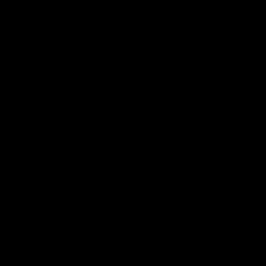

In [20]:
cv2_imshow(img)

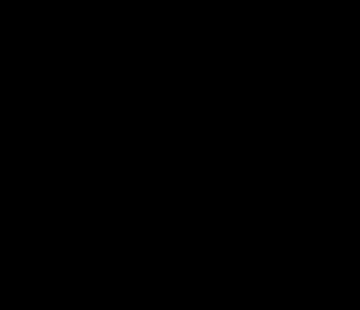

In [22]:
img1 = cv2.imread('/content/train/case110/case110_day12/scans/slice_0001_360_310_1.50_1.50.png')
cv2_imshow(img1)

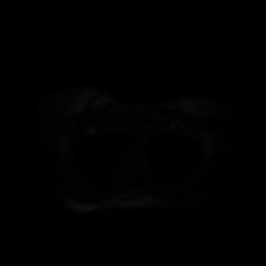

In [23]:
img2 = cv2.imread('/content/train/case43/case43_day0/scans/slice_0001_266_266_1.50_1.50.png')
cv2_imshow(img2)

In [37]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize

In [25]:
# Data Preparation: 
# Defining the Paths:

train_dir = '/content/train'
train_meta_data = '/content/train.csv'

In [26]:
train_df = pd.read_csv(train_meta_data)
train_df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [27]:
#PreProcessing : 

train_df["segmentation"] = train_df["segmentation"].astype("str")
train_df["case_id"] = train_df["id"].apply(lambda x: x.split("_")[0][4:])
train_df["day_id"] = train_df["id"].apply(lambda x: x.split("_")[1][3:])
train_df["slice_id"] = train_df["id"].apply(lambda x: x.split("_")[-1])

In [28]:
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001
2,case123_day20_slice_0001,stomach,nan,123,20,0001
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002


In [30]:
from glob import glob

In [31]:
# Extracting the image paths from the imageIds

def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
train_df["path"] = train_df["id"].apply(lambda x: fetch_file_from_id(train_dir, x))
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id,path
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...
2,case123_day20_slice_0001,stomach,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...


In [32]:
train_df["height"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype("int")
train_df["width"] = train_df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype("int")
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id,path,height,width
0,case123_day20_slice_0001,large_bowel,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
1,case123_day20_slice_0001,small_bowel,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
2,case123_day20_slice_0001,stomach,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
3,case123_day20_slice_0002,large_bowel,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...,266,266
4,case123_day20_slice_0002,small_bowel,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...,266,266


In [33]:
train_df["class"].unique()

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

In [34]:
# We will be label encoding the class variables.

class_names = train_df["class"].unique()
for index, label in enumerate(class_names):
    # replacing class names with indexes
    train_df["class"].replace(label, index, inplace = True)
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id,path,height,width
0,case123_day20_slice_0001,0,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
1,case123_day20_slice_0001,1,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
2,case123_day20_slice_0001,2,nan,123,20,0001,/content/train/case123/case123_day20/scans/sli...,266,266
3,case123_day20_slice_0002,0,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...,266,266
4,case123_day20_slice_0002,1,nan,123,20,0002,/content/train/case123/case123_day20/scans/sli...,266,266


Mask Generation Methodology :
The Segmentation mask given in this place are in RLE (RUN LENGTH ENCODING) format.

At first we have to understand how the format is :
We can consider the given data has a particular shape , let's say height is H and width is W.
Now we can consider the data in a flattened manner i.e. shape of the data is (batch_size, H*W).
The mask values are seperated by a space where every pair of value holds the valid infomation.
The first value of the pair holds the sarting index of the mask in the flattened grid.
The second value of the pair holds the length of mask from that starter pixel.
So basically we can say , every element in the odd position holds the starter index and rest holds the length of the presence of the mask.
Now , to process the mask what we can do :
Split the odd elements and he even ones into different array which correspond length of present mask pixels and starter indexes.
Add all the indexes that must be masked.
Reshape the flattened array to image grid.
Adding utility functions to process mask and images

In [35]:
def prepare_mask_data(string):
    # fetching all the values from the string
    all_values = map(int, string.split(" "))
    # preparing the usable arrays
    starterIndex, pixelCount = [], []
    for index, value in enumerate(all_values):
        if index % 2:
            # storing even indexed values in pixelCount
            pixelCount.append(value)
        else:
            # storing odd indexed values in starterIndex
            starterIndex.append(value)
    return starterIndex, pixelCount
    
def fetch_pos_pixel_indexes(indexes, counts):
    final_arr = []
    for index, counts in zip(indexes, counts):
        # adding all the values from starterIndex to range of positive pixel counts
        final_arr += [index + i for i in range(counts)]
    return final_arr

def prepare_mask(string, height, width):
    # preparing the respective arrays
    indexes, counts = prepare_mask_data(string)
    # preparing all the pixel indexes those have mask values
    pos_pixel_indexes = fetch_pos_pixel_indexes(indexes, counts)
    # forming the flattened array
    mask_array = np.zeros(height * width)
    # updating values in the array
    mask_array[pos_pixel_indexes] = 1
    # reshaping the masks
    return mask_array.reshape(height, width)

def load_image(path):
    # loading the image in RGB format
    image = Image.open(path).convert('RGB')
    return image

# DataSet Preparation

In [38]:
class UWDataset(Dataset):
    
    def __init__(self, meta_df, h=256, w=256):
        super().__init__()
        self.meta_df = meta_df
        self.h = h
        self.w = w
        self.resize = Resize((h, w))
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # fetching image path
        path = self.meta_df.loc[index, "path"]
        # loading image
        image = load_image(path)
        # loading mask's original height, width
        mask_h, mask_w = self.meta_df.loc[index, "height"], self.meta_df.loc[index, "width"]
        # loading the segmentation encoding for maks preparation
        mask_string = self.meta_df.loc[index, "segmentation"]
        # laoding the mask
        main_mask_channel = self.load_mask(string=mask_string, h=mask_h, w=mask_w)
        # updating those in tensor format
        image = ToTensor()(self.resize(image))
        main_mask_channel = ToTensor()(self.resize(main_mask_channel))
        # loading the original mask
        mask = torch.zeros((3, self.h, self.w))
        # loading the class label
        class_label = self.meta_df.loc[index, "class"]
        mask[class_label, ...] = main_mask_channel
        
        return image, mask
    
    def load_mask(self, string, h, w):
        # cheking if the segmentation encoding is a valid mask or null values
        if string != "nan":
            return Image.fromarray(prepare_mask(string, h, w))
        return Image.fromarray(np.zeros((h, w)))

In [39]:
#Parameters
SEED  = 42
BATCH_SIZE = 64
import warnings
warnings.filterwarnings("ignore")

In [40]:
ds = UWDataset(train_df)
print(f"Length of the dataset : {len(ds)}") #length of the dataset

Length of the dataset : 115488


In [41]:
image, mask = ds[194]
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [42]:
combined_im_mask = torch.cat([image, mask], dim=2)

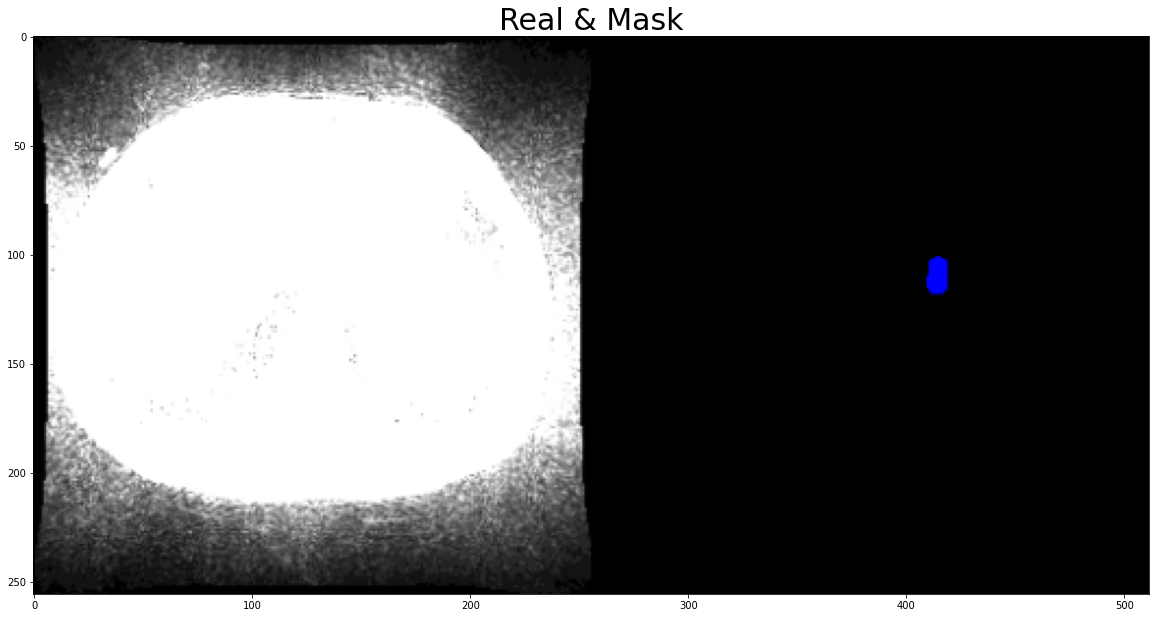

In [43]:
def show_image(tensor_image, name):
    plt.figure(figsize=(20, 20))
    plt.imshow(tensor_image.permute(1,2,0))
    plt.title(name, size=30)
    plt.show()
show_image(combined_im_mask, "Real & Mask")

Train & Validation Split

In [44]:
train_size = int(len(ds)*0.8)
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(f"Length of the training dataset : {len(train_ds)}")
print(f"Length of the validation dataset : {len(val_ds)}")

Length of the training dataset : 92390
Length of the validation dataset : 23098


In [45]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle = True, drop_last = True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

In [46]:
for train_image_batch, train_mask_batch in train_dl:
    break
for val_image_batch, val_mask_batch in val_dl:
    break

In [47]:
train_batch = torch.cat([make_grid(train_image_batch, nrow=8), make_grid(train_mask_batch, nrow=8)], dim=2)
val_batch = torch.cat([make_grid(val_image_batch, nrow=8), make_grid(val_mask_batch, nrow=8)], dim=2)

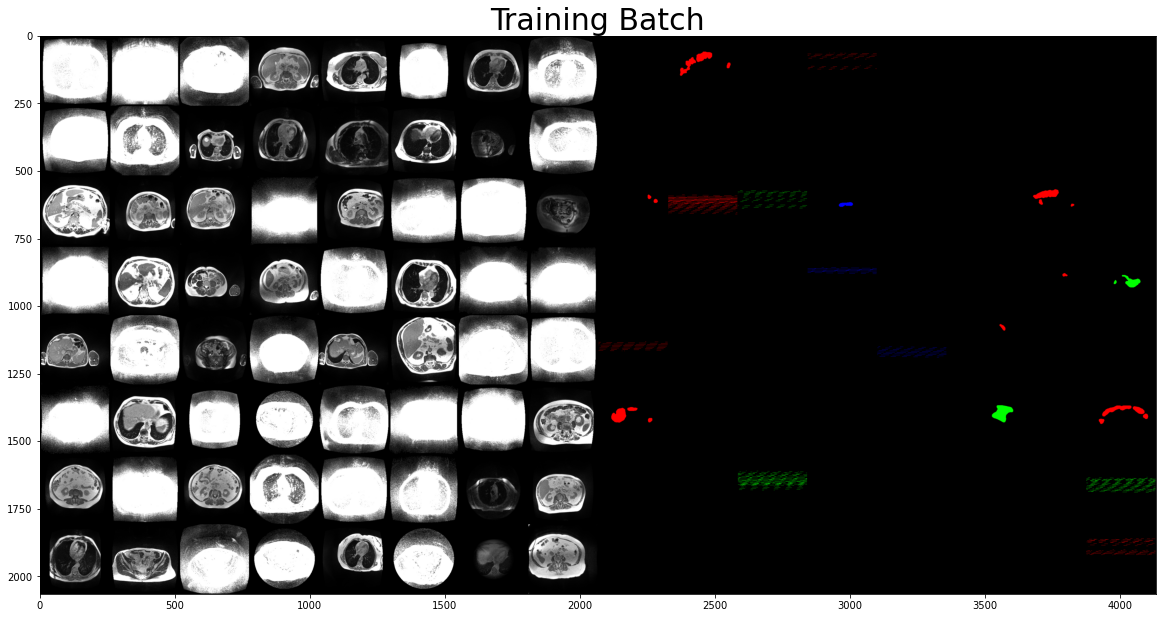

In [48]:
show_image(train_batch, "Training Batch")

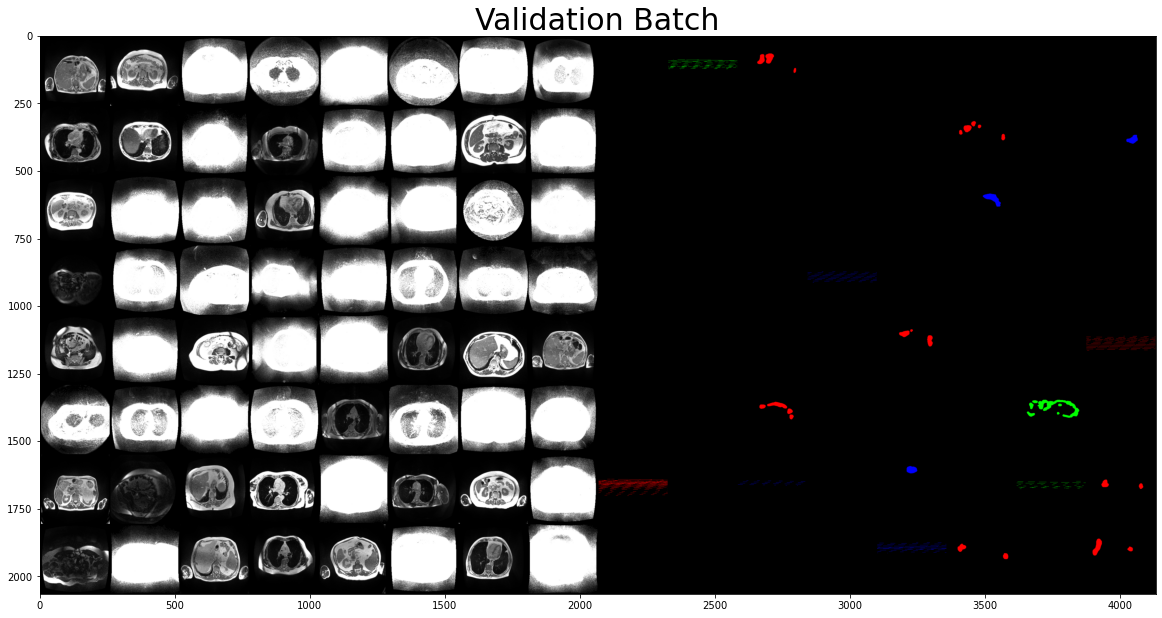

In [49]:
show_image(val_batch, "Validation Batch")